Intention is to train the network incorporating the following rules:

1. Refer to Assignment 12 code.
2. Replace the model with the ResNet18 model as shown below.
3. The model must look like Conv->B1->B2->B3->B4 and not individually called Convs. 
4. If not already using, then:
 * Use Batch Size 128
 * Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
 * Random Crop of 32 with padding of 4px
 * Horizontal Flip (0.5)
 * Optimizer: SGD, Weight-Decay: 5e-4
 * OneCycleLR
5. Save model (to drive) after every 50 epochs or best model till now
6. Describe blocks, and the stride strategy you have picked
7. Train for 300 Epochs
8. Assignment Target Accuracy is 90%, so exit gracefully if you reach 90% (you can target more, it can go till ~93%)



# Import libraries

In [1]:
import time
import math
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(1234) 
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import MaxPooling2D, SeparableConv2D, Convolution2D, Conv2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dropout, Input, Lambda, add, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import backend as K

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.layers.advanced_activations import ReLU
import tensorflow as tf
from keras.layers.merge import concatenate

import cv2
from keras.preprocessing import image
from google.colab.patches import cv2_imshow

import matplotlib.gridspec as gridspec

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Using TensorFlow backend.


# Define functions

In [0]:
def get_cifar10_data():
    from keras.datasets import cifar10
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
    num_train, img_channels, img_rows, img_cols =  train_features.shape
    num_test, _, _, _ =  test_features.shape
    num_classes = len(np.unique(train_labels))

    # Flatten 32x32x3 images to a 1024*3 vector for each image.
    train_features = train_features.reshape(train_features.shape[0], 32, 32, 3)
    test_features = test_features.reshape(test_features.shape[0], 32, 32, 3)

    train_features = train_features.astype('float32')/255
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    train_labels = np_utils.to_categorical(train_labels, num_classes)
    test_labels = np_utils.to_categorical(test_labels, num_classes)
    return (train_features, train_labels), (test_features, test_labels)

def get_cifar10_labels():
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
    return class_names

def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()
        
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()    
        
# Cut-out
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, random_crop_size=(32, 32), padding_for_crop=4, pixel_level=True):
  
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img
      
    def random_crop(input_img):
        # Note: image_data_format is 'channel_last'
        assert input_img.shape[2] == 3
        
        img = cv2.copyMakeBorder(input_img, padding_for_crop, padding_for_crop, padding_for_crop, padding_for_crop, cv2.BORDER_REPLICATE)
        
        height, width = img.shape[0], img.shape[1]
        
        dy, dx = random_crop_size
        
        x = np.random.randint(0, width - dx + 1)
        
        y = np.random.randint(0, height - dy + 1)
        
        return img[y:(y+dy), x:(x+dx), :]
      
    def do_preproc(input_image):
      return eraser(random_crop(input_image))
      
    return do_preproc
  
# Min-Max scale  
def min_max_scale(X):
    return (X - np.min(X))/(np.max(X)-np.min(X))  
  
def denormalize(img):
  return (img*datagen_validation.std + datagen_validation.mean)/255  

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate  

# Define OneCycleLR class

In [0]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K



class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                    self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                    self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                    self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))

# LR Finder class

In [0]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K

import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import pandas as pd


def detect_local_minima(arr):
    
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    neighborhood = morphology.generate_binary_structure(len(arr.shape), 2)
    local_min = (filters.minimum_filter(arr, footprint=neighborhood) == arr)
    background = (arr == 0)
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)


def moving_average_fast(x, w):
    return np.convolve(np.array(x), np.ones(w), 'same') / w


def moving_average(x, w):
    df = pd.DataFrame({"x": x})
    return df.rolling(w, win_type=None, min_periods=1, center=True).mean()['x'].values


from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model, num_validation_batches=10):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9
        self.num_validation_batches = num_validation_batches
        self.validation_set = None
        self.validation_generator = None

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss

        if self.validation_set is not None:
            X, Y = self.validation_set[0], self.validation_set[1]

            # use 10 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.num_validation_batches

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        elif self.validation_generator is not None:
            values = self.model.evaluate_generator(self.validation_generator, steps=self.num_validation_batches, )
            # print(values[0],logs['loss'])
            loss = values[0]
        else:
            loss = logs['loss']

        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 10 and (math.isnan(loss) or loss > self.best_loss * 8):
            self.model.stop_training = True
            print("Stop Training at %s, loss = %.3f" % (batch, loss))
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr,
             x_test=None, y_test=None,
             batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))
        self.validation_set = (x_test, y_test) if x_test is not None and y_test is not None else None
        self.batch_size = batch_size

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=0,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr,
                       test_generator=None,
                       epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch * epochs))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.validation_generator = test_generator

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 verbose=0,
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=5, n_skip_end=5, sma=10):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")

        losses = self.losses
        losses = moving_average(losses, sma)

        losses = losses[n_skip_beginning:-n_skip_end]

        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], losses)
        plt.xscale('log')
        best_lrs = self.get_best_lrs(sma)
        lrs = [x for x, _ in best_lrs]
        positions = [x for _, x in best_lrs]
        # https://matplotlib.org/users/annotations_intro.html
        for lr, pos in [best_lrs[-1]]:
            ax.annotate('LR = %.3f, Loss = %.3f' % (lr, losses[pos]), xy=(lr, losses[pos]),
                        xytext=(lr + 0.2, losses[pos] + 0.1),
                        arrowprops=dict(facecolor='black', shrink=0.03, width=1, frac=0.05),
                        )

        title = "LR-Loss Graph"
        title = title + "\n" + "Best Candidate LR = %s" % lrs
        title = title + "\n" + "These Candidate LRs denote the positions of minima/troughs in LR-Loss graph"
        plt.title(title)
        plt.show()

    def get_derivatives(self, sma=10):
        assert sma >= 1
        derivatives = [0] * sma
        losses = moving_average(self.losses, 5)
        for i in range(sma, len(self.lrs)):
            derivatives.append((losses[i] - losses[i - sma]) / sma)
        return derivatives

    def __get_best_lr_method1__(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        losses = np.array(self.losses[n_skip_beginning:-n_skip_end])
        derivatives = derivatives[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]

        idxs = np.where(losses >= self.best_loss * 2)[0]
        idxs = idxs[0]
        derivatives = derivatives[:idxs + sma]
        losses = losses[:idxs + sma]
        lrs = lrs[:idxs + sma]

        best_idxs = np.argpartition(derivatives[:idxs], -5)[-5:]
        best_idxs = best_idxs - sma
        acceptable_loss_or_not = losses[best_idxs] <= self.best_loss * 4
        best_idxs = best_idxs[acceptable_loss_or_not]

        acceptable_loss_or_not = losses[best_idxs + sma] > (losses[best_idxs] * 1.05)
        best_idxs = best_idxs[acceptable_loss_or_not]

        candidates = list(np.array(lrs)[best_idxs])
        return sorted(candidates), best_idxs

    def get_best_lrs(self, sma, n_skip_beginning=10, n_skip_end=5):
        c1, i1 = self.__get_best_lr_method1__(sma, n_skip_beginning, n_skip_end)
        candidates = list(zip(c1, i1))
        candidates = sorted(candidates, key=lambda pair: pair[0])
        final_candidates = [candidates[0]]
        for v, i in candidates:
            if (v - final_candidates[-1][0]) / final_candidates[-1][0] > 0.2:
                final_candidates.append((v, i))
        final_candidates = list(map(lambda pair: (float("%.3f" % pair[0]), pair[1]), final_candidates))
        return final_candidates

# Normalise using the Batch Size 128

170500096/170498071 [==============================] - 6s 0us/step


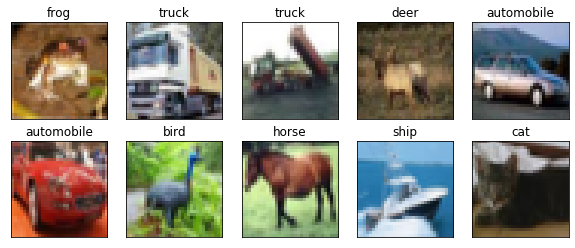

In [5]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

#  load cifar10 data  
(train_features, train_labels), (test_features, test_labels) = get_cifar10_data()

cutout_fn = get_cutout_eraser(p=0.75, s_l=0.1, s_h=0.3, r_1=0.3, r_2=1 / 0.3, 
                              max_erasures_per_image=2, 
                              random_crop_size=(32, 32), 
                              padding_for_crop=4, 
                              pixel_level=True)

datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=(0.4914, 0.4822, 0.4465),  
                             samplewise_std_normalization=(0.2023, 0.1994, 0.2010),
                             horizontal_flip=0.5,   # randomly flip images                       
                             preprocessing_function=cutout_fn)
datagen.fit(train_features)

datagen_validation = ImageDataGenerator(featurewise_center=True,
                                        featurewise_std_normalization=(0.4914, 0.4822, 0.4465),
                                        samplewise_std_normalization=(0.2023, 0.1994, 0.2010),
                                        horizontal_flip=0.5,   # randomly flip images                                          
                                       )
datagen_validation.fit(train_features)

show_examples(train_features[0:10], train_labels[0:10], classes=get_cifar10_labels())

# Model Architecture: ResNet18

Conv->B1->B2->B3->B4

In [0]:
# Define the ResNet18 blocks Architecture
def Block1(x):
  t   = ZeroPadding2D(padding=(1, 1))(x)
  x1  = Conv2D(64, kernel_size=3, activation='relu')(t)#56,64
  x2  = BatchNormalization()(x1)
  t1  = ZeroPadding2D(padding=(1, 1))(x2)
  x3  = Conv2D(64, kernel_size=3, activation='relu')(t1)#56,64
  x4  = BatchNormalization()(x3)
  x5  = add([x,x4])
  t2  = ZeroPadding2D(padding=(1, 1))(x5)
  x6  = Conv2D(64, kernel_size=3, activation='relu')(t2)#56,64
  x7  = BatchNormalization()(x6)
  t3  = ZeroPadding2D(padding=(1, 1))(x7)
  x8  = Conv2D(64, kernel_size=3, activation='relu')(t3)#56,64
  x9  = BatchNormalization()(x8)
  x10 = add([x5,x9])
  return (x10)

def Block2(x):
  t   = ZeroPadding2D(padding=(1, 1))(x)
  x1  = Conv2D(128, kernel_size=3, activation='relu', strides=2)(t)#26,128
  x2  = BatchNormalization()(x1)
  t1  = ZeroPadding2D(padding=(1, 1))(x2)
  x3  = Conv2D(128, kernel_size=3, activation='relu')(t1)#26,128
  x4  = BatchNormalization()(x3)
  r   = Conv2D(128, kernel_size=1, activation='relu',strides=2)(x)
  x5  = add([r,x4])
  t2  = ZeroPadding2D(padding=(1, 1))(x5)
  x6  = Conv2D(128, kernel_size=3, activation='relu')(t2)#26,128
  x7  = BatchNormalization()(x6)
  t3  = ZeroPadding2D(padding=(1, 1))(x7)
  x8  = Conv2D(128, kernel_size=3, activation='relu')(t3)#26,128
  x9  = BatchNormalization()(x8)
  x10 = add([x5,x9])
  return (x10)

def Block3(x):
  t   = ZeroPadding2D(padding=(1, 1))(x)
  x1  = Conv2D(256, kernel_size=3, activation='relu', strides=2)(t)#56,64
  x2  = BatchNormalization()(x1)
  t1  = ZeroPadding2D(padding=(1, 1))(x2)
  x3  = Conv2D(256, kernel_size=3, activation='relu')(t1)#56,64
  x4  = BatchNormalization()(x3)
  r   = Conv2D(256, kernel_size=1, activation='relu',strides=2)(x)
  x5  = add([r,x4])
  t2  = ZeroPadding2D(padding=(1, 1))(x5)
  x6  = Conv2D(256, kernel_size=3, activation='relu')(t2)#56,64
  x7  = BatchNormalization()(x6)
  t3  = ZeroPadding2D(padding=(1, 1))(x7)
  x8  = Conv2D(256, kernel_size=3, activation='relu')(t3)#56,64
  x9  = BatchNormalization()(x8)
  x10 = add([x5,x9])
  return (x10)

def Block4(x):
  t   = ZeroPadding2D(padding=(1, 1))(x)
  x1  = Conv2D(512, kernel_size=3, activation='relu', strides=2)(t)#56,64
  x2  = BatchNormalization()(x1)
  t1  = ZeroPadding2D(padding=(1, 1))(x2)
  x3  = Conv2D(512, kernel_size=3, activation='relu')(t1)#56,64
  x4  = BatchNormalization()(x3)
  r   = Conv2D(512, kernel_size=1, activation='relu',strides=2)(x)
  x5  = add([r,x4])
  t2  = ZeroPadding2D(padding=(1, 1))(x5)
  x6  = Conv2D(512, kernel_size=3, activation='relu')(t2)#56,64
  x7  = BatchNormalization()(x6)
  t3  = ZeroPadding2D(padding=(1, 1))(x7)
  x8  = Conv2D(512, kernel_size=3, activation='relu')(t3)#56,64
  x9  = BatchNormalization()(x8)
  x10 = add([x5,x9])
  return (x10)

# Define the model
def build_model(summary=False, lrate=0.0):
    
    input = Input(shape=(32, 32, 3,))
        
    t  = ZeroPadding2D(padding=(3, 3))(input)
    x1 = Conv2D(64, kernel_size=3, activation='relu',strides= 2)(t)#112,64
    t1 = BatchNormalization()(x1)
    x2 = MaxPooling2D(pool_size=(2, 2),)(t1)#56,64
    x3 = Block1(x2)
    x4 = Block2(x3)
    x5 = Block3(x4)
    x6 = Block4(x5)
    x7 = Convolution2D(10, 1, 1) (x6)
    x8 = AveragePooling2D()(x7)

    x = Flatten() (x8)

    output = Activation('softmax') (x)
    
    model = Model(inputs=[input], outputs=[output])
    
    sgd = SGD(lr=lrate, momentum=0.9, decay=5e-4, nesterov=False)
  
    model.compile(optimizer= sgd,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])    
    
    #Print model summary
    if (summary == True):
        model.summary()
    
    return model

# Train the network

In [0]:
def train_network(model, epochs=25, lr_scheduling_fn=None, one_cycle_start_lr=None, step_decay_lr=False):
      
    save_mcp = ModelCheckpoint('best_model_Ass13.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
          
    train_iterator      = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=True)
    validation_iterator = datagen_validation.flow(test_features, test_labels, batch_size=batch_size, shuffle=True)
    
    callbacks=[save_mcp]
    lr_schedule = LearningRateScheduler(lr_scheduling_fn) if lr_scheduling_fn is not None else None
    
    lr_step = LearningRateScheduler(step_decay) if step_decay_lr is True else None
    
    if lr_schedule is not None:
       callbacks.append(lr_schedule)
        
    if lr_step is not None:
      callbacks.append(lr_step)      
        
    ################OneCycleLR###################################        
    if one_cycle_start_lr is not None:             
      lr_one_cycle = OneCycleLR(epochs=epochs,
                                batch_size=batch_size,
                                samples = len(test_labels),
                                steps = len(train_iterator),
                                max_lr=one_cycle_start_lr)  
      callbacks.append(lr_one_cycle) 
    #############################################################        
    
    # Train the model
    start = time.time() 
                              
    train_history = model.fit_generator(train_iterator,
                                        steps_per_epoch  = len(train_iterator), 
                                        validation_data  = validation_iterator, 
                                        validation_steps = len(validation_iterator),
                                        epochs           = epochs, 
                                        verbose          = 2,
                                        callbacks        = callbacks)    

    model.load_weights("best_model_Ass13.h5")
      
    end = time.time()
    print ("Model took %0.2f seconds to train \n"%(end - start))

    # plot model history
    if (epochs > 1):
        plot_model_history(train_history)

    return train_history    

# Build the model

In [8]:
model = build_model(summary=True)
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 18, 18, 64)   1792        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 18, 18, 64)   256         conv2d_1[0][0]   

# Train the network for 100 epochs



Epoch 1/100
 - 30s - loss: 0.2586 - acc: 0.9053 - val_loss: 0.2115 - val_acc: 0.9178

Epoch 00001: val_acc improved from -inf to 0.91781, saving model to best_model_Ass13.h5
Epoch 2/100
 - 23s - loss: 0.2210 - acc: 0.9144 - val_loss: 0.1899 - val_acc: 0.9255

Epoch 00002: val_acc improved from 0.91781 to 0.92546, saving model to best_model_Ass13.h5
Epoch 3/100
 - 23s - loss: 0.2046 - acc: 0.9198 - val_loss: 0.1752 - val_acc: 0.9306

Epoch 00003: val_acc improved from 0.92546 to 0.93061, saving model to best_model_Ass13.h5
Epoch 4/100
 - 24s - loss: 0.1940 - acc: 0.9237 - val_loss: 0.1674 - val_acc: 0.9346

Epoch 00004: val_acc improved from 0.93061 to 0.93459, saving model to best_model_Ass13.h5
Epoch 5/100
 - 23s - loss: 0.1852 - acc: 0.9274 - val_loss: 0.1599 - val_acc: 0.9360

Epoch 00005: val_acc improved from 0.93459 to 0.93605, saving model to best_model_Ass13.h5
Epoch 6/100
 - 23s - loss: 0.1780 - acc: 0.9295 - val_loss: 0.1487 - val_acc: 0.9406

Epoch 00006: val_acc improved 

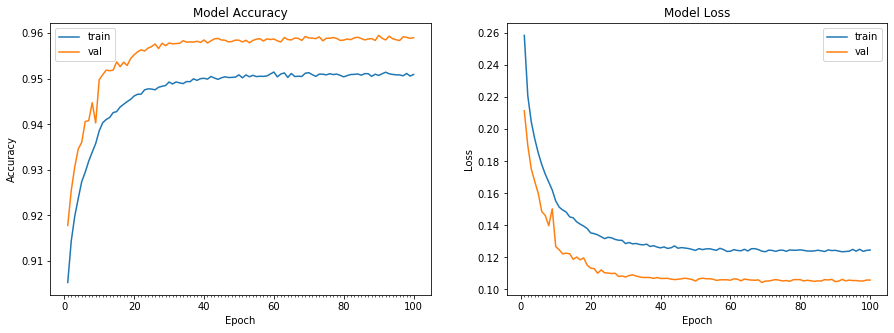

In [9]:
train_history = train_network(model, epochs=100, step_decay_lr=True)

# Giving an whirl using LR 
Identify the Best LR

In [10]:
lrf = LRFinder(model)

generator = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=True)                             
test_generator = datagen_validation.flow(test_features, test_labels, batch_size=batch_size, shuffle=True)

lrf.find_generator(generator, 0.0001, 10.0, test_generator, epochs=1, steps_per_epoch=None,)

Stop Training at 387, loss = 0.929


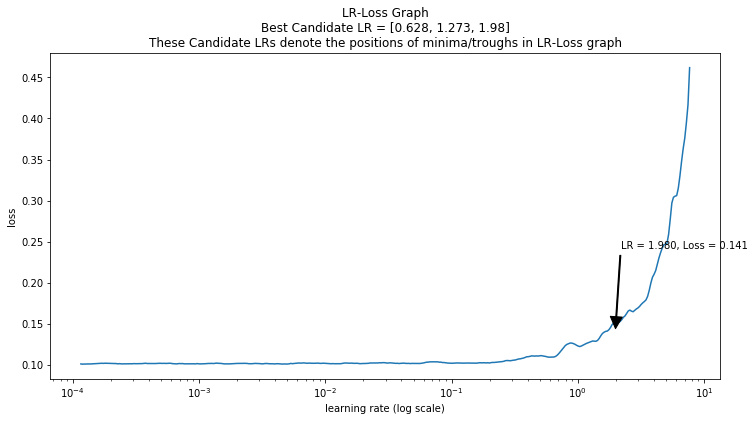

In [11]:
lrf.plot_loss()

# Run OneCycleLR with the initial LR rate equal to best LR found 

Epoch 1/100
 - 26s - loss: 0.2609 - acc: 0.9053 - val_loss: 0.2179 - val_acc: 0.9145

Epoch 00001: val_acc improved from -inf to 0.91446, saving model to best_model_Ass13.h5
 - lr: 0.13182 - momentum: 0.95 
Epoch 2/100
 - 24s - loss: 0.2213 - acc: 0.9142 - val_loss: 0.1877 - val_acc: 0.9258

Epoch 00002: val_acc improved from 0.91446 to 0.92582, saving model to best_model_Ass13.h5
 - lr: 0.15380 - momentum: 0.95 
Epoch 3/100
 - 24s - loss: 0.2066 - acc: 0.9192 - val_loss: 0.1809 - val_acc: 0.9278

Epoch 00003: val_acc improved from 0.92582 to 0.92783, saving model to best_model_Ass13.h5
 - lr: 0.17578 - momentum: 0.94 
Epoch 4/100
 - 24s - loss: 0.1946 - acc: 0.9235 - val_loss: 0.1713 - val_acc: 0.9319

Epoch 00004: val_acc improved from 0.92783 to 0.93195, saving model to best_model_Ass13.h5
 - lr: 0.19776 - momentum: 0.94 
Epoch 5/100
 - 25s - loss: 0.1833 - acc: 0.9277 - val_loss: 0.1525 - val_acc: 0.9392

Epoch 00005: val_acc improved from 0.93195 to 0.93916, saving model to best_m

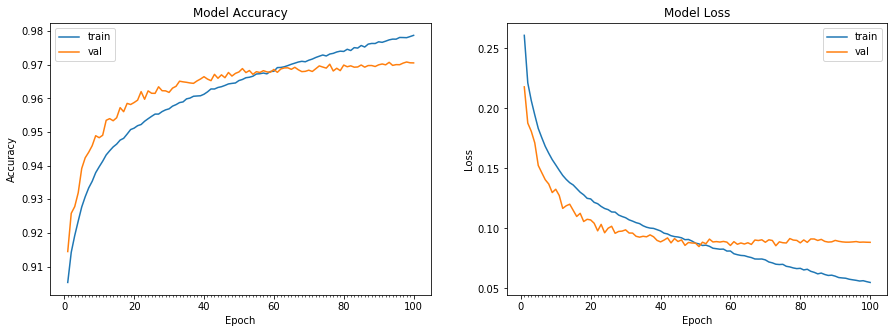

In [12]:
# reset the model weights
model1 = build_model()
train_history = train_network(model1, epochs=100, one_cycle_start_lr=1.099)

# Conclusion:

ResNet18 network is implemented and initially trained to run for 100 epochs and validation accuracy of 95.954% was achieved. 

## Given an whirl to run by using Learning Rate
Rerunning the model using this method for 100 epochs has improved the validation accuracy to 97.06%





